# Creating a Video for Training Each Style

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict

def get_structured_data(data):
    key_value_tups = (OrderedDict(element.split(' = ') for element in line.split('; ')) for line in data)
    return pd.DataFrame(key_value_tups)

test_dirname = 'test_dir_water_lilies/' ### hard coded


with open(test_dirname + 'runtime_water_lilies.txt') as f: ## hard coded file name
    data = f.read().splitlines()
    useful_data = [line for line in data if 'Current Time' in line]
    structured_data = get_structured_data(useful_data)
    structured_data[['Epoch', 'Iteration']] = structured_data[['Epoch', 'Iteration']].astype('int')
    structured_data[['Loss', 'Time Elapsed']] = structured_data[['Loss', 'Time Elapsed']].astype('float32')
    structured_data.set_index(structured_data.index * 50, inplace=True) ### hard coded to 50 iterations

In [14]:
%%time
import imageio
from datetime import datetime, timedelta

seconds_between_frames = 30 # represents seconds of time for training
max_length_in_seconds = 60 * 60 * 8 ## hard coded to represent maximum length of training time
output_filename = test_dirname + 'movie.mp4'

image_filenames = []
next_frame_timestamp = None
for row_id, row in structured_data.iterrows():
    if row_id == 0:
        start_time = (datetime.strptime(row['Current Time'], "%Y %B %d, %H:%M:%S") -
                      timedelta(seconds=int(row['Time Elapsed'])))
        next_frame_timestamp = start_time
        while next_frame_timestamp < datetime.strptime(row['Current Time'], "%Y %B %d, %H:%M:%S"):
            image_filenames.append("{}{}_{}.png".format(test_dirname, row['Epoch'], row['Iteration']))
            next_frame_timestamp += timedelta(seconds=seconds_between_frames)
            
    else:
        while next_frame_timestamp < datetime.strptime(row['Current Time'], "%Y %B %d, %H:%M:%S"):
            image_filenames.append("{}{}_{}.png".format(test_dirname, row['Epoch'], row['Iteration']))
            next_frame_timestamp += timedelta(seconds=seconds_between_frames)        
        
image_sequence = []
for filename in image_filenames[:max_length_in_seconds // seconds_between_frames]:
    image_sequence.append(imageio.imread(filename))
imageio.mimsave(output_filename, image_sequence, fps=48) ### fps hard coded

CPU times: user 27.3 s, sys: 1.09 s, total: 28.4 s
Wall time: 32.1 s


# Stitch all Videos Together

In [1]:
import moviepy.editor as mpe
import numpy as np
from glob import glob

movies = []
for movie_filename in sorted(glob('test_dir*/movie.mp4*')):
    movies.append(mpe.VideoFileClip(movie_filename).margin(10)) ### border margin hard coded

all_clips = np.array(movies).reshape(2, 4)
final_clip = mpe.clips_array(all_clips)
final_clip.write_videofile('combined_movie.mp4')

[MoviePy] >>>> Building video combined_movie.mp4
[MoviePy] Writing video combined_movie.mp4


100%|██████████| 873/873 [02:50<00:00,  5.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: combined_movie.mp4 



# Plot Metrics

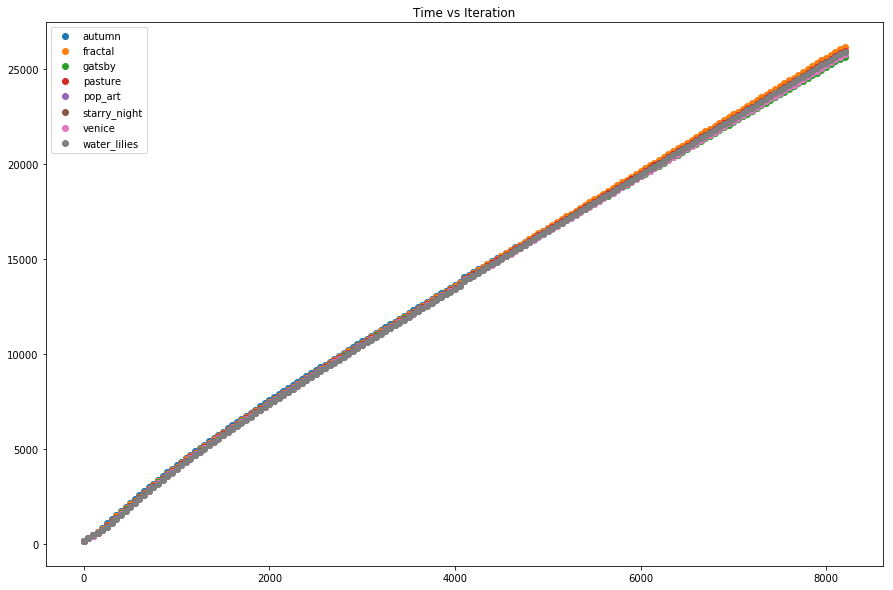

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict
from glob import glob

def get_structured_data(data):
    key_value_tups = (OrderedDict(element.split(' = ') for element in line.split('; ')) for line in data)
    return pd.DataFrame(key_value_tups)

plt.figure(figsize=(15, 10))

for runtime_file in sorted(glob('test_dir_*/runtime_*')):
    with open(runtime_file) as f:
        data = f.read().splitlines()
        useful_data = [line for line in data if 'Current Time' in line]
        structured_data = get_structured_data(useful_data)
        structured_data[['Epoch', 'Iteration']] = structured_data[['Epoch', 'Iteration']].astype('int')
        structured_data[['Loss', 'Time Elapsed']] = structured_data[['Loss', 'Time Elapsed']].astype('float32')
        structured_data.set_index(structured_data.index * 50, inplace=True) ### hard coded to 50 iterations

    structured_data['Time Elapsed'].cumsum().plot(title="Time vs Iteration", marker='o', linestyle='None', label=runtime_file.split('/')[0].replace('test_dir_', ''))
plt.legend()